# Build a machine learning pipeline with Spark ML
Continuing feature extraction and training and evaluating models for churn prediction.
This notebook explores anomaly detection using clustering techniques.

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# The code was removed by DSX for sharing.

In [3]:
spark.version

'2.0.2'

In [4]:
# Allow display of multiple values without using print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import pixiedust

Pixiedust database opened successfully


# Read Per-Account Time Sequence Data

In [31]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
seqs = (spark.read
             .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')
             .option('header', 'true')
             .load(bmos.url('CableCompany', 'accountTimeSeries.csv')))
df.show(5)

+-----------+-----------------+-----------------+------------------------+--------------------+---------------+--------+------------------+----------------+---------------------+
|  AccountId|       OrderClass|      OrderStatus|AccountDelinquencyStatus|     OrderReasonCode|NumInteractions|IsNormal|     FractionNoPay|FractionTransfer|IsVoluntaryDisconnect|
+-----------+-----------------+-----------------+------------------------+--------------------+---------------+--------+------------------+----------------+---------------------+
|00010043819|       SSSSSSSSSS|       OOCOOOOOOC|              NNNNNNNNNN|DF.DF.DF.DF.DF.DF...|           10.0|     1.0|               0.0|             0.0|                  0.0|
|00010221159|SSSSSSSSSTTSSSSSS|OOXOOXOOXOXCOOOXO|       AWNAWNAWNNNNNNNNN|NP.NP.NP.NP.NP.NP...|           17.0|     0.0|0.5294117647058824|             0.0|                  0.0|
|00010271483|               SS|               OC|                      NN|               NT.SE|          

In [7]:
display(seqs)

AccountId,OrderClass,OrderStatus,AccountDelinquencyStatus,OrderReasonCode
00010043819,SSSSSSSSSS,OOCOOOOOOC,NNNNNNNNNN,DF.DF.DF.DF.DF.DF.DF.DF.DF.DF
00010221159,SSSSSSSSSTTSSSSSS,OOXOOXOOXOXCOOOXO,AWNAWNAWNNNNNNNNN,NP.NP.NP.NP.NP.NP.NP.NP.NP.01.01.NT.SJ.SJ.SJ.SJ.DF
00010271483,SS,OC,NN,NT.SE
00010271491,SS,OC,NN,NT.SE
00010380306,SSSSSSSSTTTSSS,OOXOOXOXOOCOOX,APNAWNANTTTAPN,NP.NP.NP.NP.NP.NP.NP.NP.D2.D2.D2.NP.NP.NP
00010504548,SS,OC,VC,OT.OT
00010678689,SSSS,OOOX,AWPN,NP.NP.NP.NP
00011650153,TSSSTSSSTTS,OCOOOOCCOCC,NNNNNNNNNNN,H5.NT.NT.NT.H5.NT.NT.DF.H5.H5.SJ
00011915788,SSSSS,CCCCC,NNCNN,NT.NT.NT.NT.NT
00012258879,SSS,OOC,NNN,DF.DF.DF


# Compute features and response variable
Create the transformers for the Spark ML pipeline and build up the pipeline incrementally. Meanwhile, keep track of the columns that make up the features and response (label).

In [8]:
# Build up a Spark ML pipeline as we go.
from pyspark.ml import Pipeline

# Initialize the pipeline variable so it can be built incrementally
# Keep track separately of the feature columns so they can be used outside the pipeline
feature_cols = []
pipeline = Pipeline(stages=[])
print('Stages so far: {}'.format(pipeline.getStages()))

Stages so far: []


### Possible feature: number of calls

In [9]:
# The total number of interactions over a given timeframe indicates how active the account was.
# OrderClass, OrderStatus, and AccountDelinquencyStatus should all have the same length, so it doesn't
# matter which column we use.
from pyspark.ml.feature import SQLTransformer

feature_cols += ['NumInteractions']

stmt = '''
SELECT *, CAST(length(OrderClass) AS DOUBLE) AS NumInteractions FROM __THIS__
'''

callCounter = SQLTransformer(statement=stmt)
print('This Transformer: {}'.format(callCounter))
pipeline = Pipeline(stages=pipeline.getStages() + [callCounter])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: SQLTransformer_4c5eb226e1aa1423e04e
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e]


### Possible feature: everything normal
In the time sequence data, a "normal" status is indicated by 'N' (empty string in the original data).
Presumably, only sequences containing a not-normal code would lead up to churn.

In [10]:
# Did all interactions have a "Normal" status?
# "Normal" means the entire sequence of status codes consists of 'N's, nothing else.

feature_cols += ['IsNormal']

# In SQL queries be careful with numeric literals. Must use 'd' (or 'D') suffix to
# indicate double-precision floating point (SQL DOUBLE). Otherwise you get DECIMAL
# (or NUMBER), which becomes BigDecimal in Java and cannot be implicitly cast to Double.
stmt = '''
SELECT *,
       CASE
         WHEN AccountDelinquencyStatus REGEXP '^N+$' THEN
           1.0d
         ELSE
           0.0d
       END
         AS IsNormal
  FROM __THIS__
'''

normalCheck = SQLTransformer(statement=stmt)
print('This Transformer: {}'.format(normalCheck))
pipeline = Pipeline(stages=pipeline.getStages() + [normalCheck])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: SQLTransformer_46729a62542211a68e75
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75]


### Possible feature: non-pay fraction
The fraction of all calls for this account that had a *Non-Pay* Reason Code

In [11]:
# x = 'AB.CD.EF.GH.CD'
x = 'ABCDEFGHCD'
x.count('CD')/(x.count('.')+1)
len(x)

2.0

10

In [12]:
from pyspark.sql.types import DoubleType

# Create a user-defined function (UDF) to support various SQL queries
# looking for the relative number of occurrences of a given code in any
# of the status, class, or reason code sequences.
# This works for single-character as well as two-character codes (or multicharacter codes in general).
# The explicit assumption is that the two-character reason codes are separated
# by a character that does not occur in the codes themselves--by default, the period.
def codeFrac(seq, code, separator='.'):
    if len(code) > 1:
        return seq.count(code)/(seq.count(separator) + 1)
    else:
        return seq.count(code)/len(seq)

spark.udf.register('codeFraction', codeFrac, DoubleType())

In [13]:
# Reason Codes record a categorization of the the reson for the call.
# One way to identify customers unwilling or unable to pay is to look for the code NP (description: P-Non Pay)
feature_cols += ['FractionNoPay']

stmt = '''
SELECT *, codeFraction(OrderReasonCode, "NP") AS FractionNoPay FROM __THIS__
'''

noPayFraction = SQLTransformer(statement=stmt)
print('This Transformer: {}'.format(noPayFraction))
pipeline = Pipeline(stages=pipeline.getStages() + [noPayFraction])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: SQLTransformer_49798965b04f83901f24
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24]


### Possible feature: transfer of service
The fraction of all calls for this account that had to do with a transfer of service, as indicated by the Reason Code sequence.

In [14]:
# Reason Codes record a categorization of the the reson for the call.
# One way to refine the definition of "churner" is to separate out those who
# disconnect for non-churn reasons, such as transferring service to a new address.
# Look for the Reason Code OT (description: P-Transfers Of Service)
feature_cols += ['FractionTransfer']

stmt = '''
SELECT *, codeFraction(OrderReasonCode, "OT") AS FractionTransfer FROM __THIS__
'''

transferFraction = SQLTransformer(statement=stmt)
print('This Transformer: {}'.format(transferFraction))
pipeline = Pipeline(stages=pipeline.getStages() + [transferFraction])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: SQLTransformer_42a4a978516ecfce5d46
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46]


### Possible response: voluntary disconnect
This would serve as the "Churner" label.

In [15]:
# Indicate whether the customer was disconnected at their request
# A voluntary disconnect is marked by a customer initiating a voluntary disconnect order (V),
# followed by the closing of that order (C) as the last interaction in the series. Other codes
# may occur between the V and the C.

response = 'IsVoluntaryDisconnect'

# In SQL queries be careful with numeric literals. Must use 'd' (or 'D') suffix to
# indicate double-precision floating point (SQL DOUBLE). Otherwise you get DECIMAL
# (or NUMBER), which becomes BigDecimal in Java and cannot be implicitly cast to Double.
stmt = '''
SELECT *,
       CASE
         WHEN AccountDelinquencyStatus REGEXP 'V[^VC]*C$' THEN
           1.0d
         ELSE
           0.0d
       END
         AS IsVoluntaryDisconnect
  FROM __THIS__
'''

churnCheck = SQLTransformer(statement=stmt)
print('This Transformer: {}'.format(churnCheck))
pipeline = Pipeline(stages=pipeline.getStages() + [churnCheck])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: SQLTransformer_4395a665cb319b0a69d3
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46, SQLTransformer_4395a665cb319b0a69d3]


## Get features and response into a separate dataframe
We can use this to verify the transformer stages defined so far. Also use it to set a baseline result, to which every model can be compared. A model must improve on the baseline, which uses no intelligence at all but simply picks the most common label.

In [ ]:
# Show results so far
df = pipeline.fit(seqs).transform(seqs)
display(df)

AccountId,OrderClass,OrderStatus,AccountDelinquencyStatus,OrderReasonCode,NumInteractions,IsNormal,FractionNoPay,FractionTransfer,IsVoluntaryDisconnect
00010043819,SSSSSSSSSS,OOCOOOOOOC,NNNNNNNNNN,DF.DF.DF.DF.DF.DF.DF.DF.DF.DF,10.0,1.0,0.0,0.0,0.0
00010221159,SSSSSSSSSTTSSSSSS,OOXOOXOOXOXCOOOXO,AWNAWNAWNNNNNNNNN,NP.NP.NP.NP.NP.NP.NP.NP.NP.01.01.NT.SJ.SJ.SJ.SJ.DF,17.0,0.0,0.5294117647058824,0.0,0.0
00010271483,SS,OC,NN,NT.SE,2.0,1.0,0.0,0.0,0.0
00010271491,SS,OC,NN,NT.SE,2.0,1.0,0.0,0.0,0.0
00010380306,SSSSSSSSTTTSSS,OOXOOXOXOOCOOX,APNAWNANTTTAPN,NP.NP.NP.NP.NP.NP.NP.NP.D2.D2.D2.NP.NP.NP,14.0,0.0,0.7857142857142857,0.0,0.0
00010504548,SS,OC,VC,OT.OT,2.0,0.0,0.0,1.0,1.0
00010678689,SSSS,OOOX,AWPN,NP.NP.NP.NP,4.0,0.0,1.0,0.0,0.0
00011650153,TSSSTSSSTTS,OCOOOOCCOCC,NNNNNNNNNNN,H5.NT.NT.NT.H5.NT.NT.DF.H5.H5.SJ,11.0,1.0,0.0,0.0,0.0
00011915788,SSSSS,CCCCC,NNCNN,NT.NT.NT.NT.NT,5.0,0.0,0.0,0.0,0.0
00012258879,SSS,OOC,NNN,DF.DF.DF,3.0,1.0,0.0,0.0,0.0


In [17]:
print('Shape: {} × {}'.format(df.count(), len(df.columns)))

Shape: 573 × 10


# Shape data for clustering

+ check for nulls

In [18]:
# Dropping any rows containing one or more nulls: there shouldn't be any so the number of rows should not change.
print('There are no nulls: {}'.format(seqs.dropna().count() == seqs.count()))

There are no nulls: True


### Gather the features into a single vector

In [19]:
# Spark wants its features as vectors in a single column
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
pipeline = Pipeline(stages=pipeline.getStages() + [assembler])
print('Stages so far: {}'.format(pipeline.getStages()))

Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46, SQLTransformer_4395a665cb319b0a69d3, VectorAssembler_450885c87ef1fdfc5f96]


+ get dummies if needed

+ scale feature data

In [20]:
# Most models work better when all features are in a similar numeric range.
from pyspark.ml.feature import MaxAbsScaler

scaler = MaxAbsScaler(inputCol='features', outputCol='scaledFeatures')
print('This Transformer: {}'.format(scaler))
pipeline = Pipeline(stages=pipeline.getStages() + [scaler])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: MaxAbsScaler_432aaa2490719db003c4
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46, SQLTransformer_4395a665cb319b0a69d3, VectorAssembler_450885c87ef1fdfc5f96, MaxAbsScaler_432aaa2490719db003c4]


In [21]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

# Helper UDF to pick expand vector column into separate columns
# This just gets from DenseVector to list, after which standard indexing works.
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

In [22]:
# Using a combination of pyspark and pandas, create a pleasing display of original
# and scaled feature means. Use a single method chain. The main challenge is to 
# expand the feature vector (DenseVector) columns into several scalar columns, one
# for each feature. That's what the function defined above is for.
# (This may be too fancy for my own good, but I just wanted to see how far I could get.)

# With MaxAbsScaler, only features that extend beyond the interval [-1,1] are affected.

(pipeline.fit(seqs)                                               # Apply the transform pipeline
         .transform(seqs)                                         # Result should be cached for reuse below
         .agg({feature_cols[i]:'avg'                              # Compute the means (averages) of the original feature columns
               for i in range(len(feature_cols))})                # Keep the 'avg(...)' names of the aggregate columns
         .union(                                                  # Combine with the scaled results
             pipeline.fit(seqs)                                       # Assume this pipeline result has been cached
                     .transform(seqs)
                     .select(to_array(col('scaledFeatures')).alias('featureList'))    # Turn the DenseVector column into a column of lists
                     .select([col('featureList')[i].alias(feature_cols[i])            # Now use simple list indexing to create a new column
                              for i in range(len(feature_cols))])                     # for each list element
                     .agg({feature_cols[i]:'avg'                                      # Compute the means of the scaled feature columns
                           for i in range(len(feature_cols))})
         )
         .toPandas()                                 # Switch to Pandas for additional table manipulation (it's now a very small dataframe)
         .assign(stage = ['original','scaled'])      # New column with useful labels
         .rename(columns={'stage': ' '})             # Don't want a visible label for this column
         .set_index(' ')                             # Use the new column as dataframe index
         .transpose()                                # Row labels become column names and vice versa
)


,original,scaled
avg(FractionTransfer),0.071234,0.071234
avg(FractionNoPay),0.135320,0.135320
avg(NumInteractions),5.773124,0.240547
avg(IsNormal),0.650960,0.650960


+ Apply Principal Components Analysis (PCA)<br/>
as a data reduction step: Combine features into a smaller set that carries the same amount of information.

In [23]:
# PCA takes only one tuning parameter: the number of components to keep
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol='scaledFeatures', outputCol='pcs')
print('This Transformer: {}'.format(pca))
pipeline = Pipeline(stages=pipeline.getStages() + [pca])
print('Stages so far: {}'.format(pipeline.getStages()))

This Transformer: PCA_4c66873569e4105684e8
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46, SQLTransformer_4395a665cb319b0a69d3, VectorAssembler_450885c87ef1fdfc5f96, MaxAbsScaler_432aaa2490719db003c4, PCA_4c66873569e4105684e8]


+ visualize data distributions after PCA

Use Pixiedust to get a plot similar to the pandas scatter matrix.

#### Instructions: 
> - Let `display()` create the table view.
> - In the **Chart** drop-down menu, select **Scatter Plot**.
> - In the **Pixiedust: Scatter Plot Options** dialog, drag *pc1* from the **Fields** box to the **Keys** box and *pc2* to the **Values** box. Click **OK**.
> - Set the **# of Rows to Display** to **1000** (something greater than the number of rows in this small dataframe).
> - In the **Renderer** selection box, select **seaborn**.
> - Resize the plot as you see fit.

This shows the same information as the pandas scatter matrix, but with a different layout.
It draws only one scatter plot (since the ones in pandas are mirror images of each other anyway)
and puts the histograms at the top (for pc1) and right side (for pc2) of the scatter plot. 


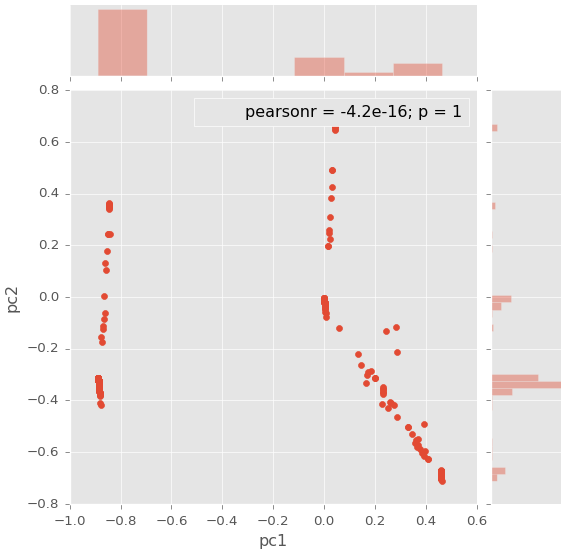

In [ ]:
# Before Pixiedust can display, must expand the feature vectors
dfv = (pipeline.fit(seqs)
               .transform(seqs)
               .select(to_array(col('pcs')).alias('pcList'))
               .select([col('pcList')[i].alias('pc{}'.format(i+1)) for i in range(2)])
      )
display(dfv)

/gpfs/fs01/user/sf08-a6bd9d84e54f1b-f5ba7b026d15/.local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


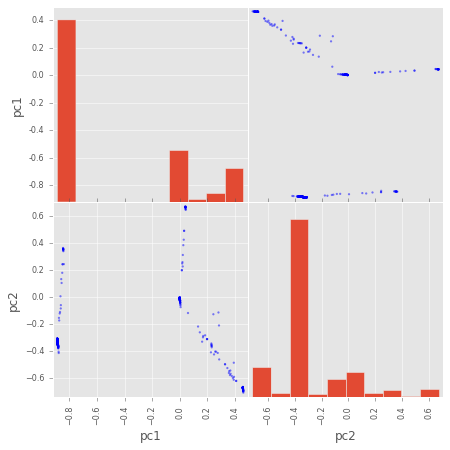

In [25]:
# For comparison, here is the equivalent pandas scatter matrix,
# showing the distributions on the diagonal and the correlations
# on the off-diagonal. Note that the off-diagonal are mirror images
# of each other (reflected over the line y=x), so you need only one.
import pandas as pd
plt.style.use('ggplot')
_ = pd.tools.plotting.scatter_matrix(dfv.toPandas(), diagonal='hist',figsize=(7,7))

+ run K-means clustering

In [26]:
K = 7

from pyspark.ml.clustering import KMeans
kMeans = KMeans(featuresCol='pcs', predictionCol='label', k=K, tol=1e-5, seed=1)
print('This Estimator: {}'.format(kMeans))
pipeline = Pipeline(stages=pipeline.getStages() + [kMeans])
print('Stages so far: {}'.format(pipeline.getStages()))

This Estimator: KMeans_4f9f802ae016c25eb021
Stages so far: [SQLTransformer_4c5eb226e1aa1423e04e, SQLTransformer_46729a62542211a68e75, SQLTransformer_49798965b04f83901f24, SQLTransformer_42a4a978516ecfce5d46, SQLTransformer_4395a665cb319b0a69d3, VectorAssembler_450885c87ef1fdfc5f96, MaxAbsScaler_432aaa2490719db003c4, PCA_4c66873569e4105684e8, KMeans_4f9f802ae016c25eb021]


+ visualize clusters

Use Pixiedust to get a plot similar to the pandas scatter matrix.

#### Instructions: 
> - Let `display()` create the table view.
> - In the **Chart** drop-down menu, select **Scatter Plot**.
> - In the **Pixiedust: Scatter Plot Options** dialog, drag *pc1* from the **Fields** box to the **Keys** box and *pc2* to the **Values** box. Click **OK**.
> - Set the **# of Rows to Display** to **1000** (something greater than the number of rows in this small dataframe).
> - In the **Renderer** selection box, select **bokeh**.
> - In the **color** selection box, select **label**.
> - Resize the plot as you see fit. For smaller sizes, the legend may obscure some of the points. Drag the plot to the right to see them.

In [27]:
# Before Pixiedust can display, must expand the feature vectors
# Carry along the original features 
dfv = (pipeline.fit(seqs)
               .transform(seqs)
               .withColumn('pcList', to_array(col('pcs')))
               .select([col(i) for i in feature_cols]
                       + [col('pcList')[i].alias('pc{}'.format(i+1)) for i in range(2)]
                       + [col('AccountId'), col('label')])
      )
display(dfv)

#### Show a similar scatter plot for two original features
Instead of the principal components, show the spread of two of the original features. Not only is the choice of two arbitrary, it hard to visualize more than two. This will show that for any choice of two original features, the separation and distribution is not as good as it is for the principal components.

Use the same instructions as above, but in the **Options** dialog choose two of the original features instead of *pc1* and *pc2*. For example, *NumInteractions* and *FractionTransfer*.

In [33]:
display(dfv)

In [29]:
dfv.groupBy('label').count().sort(col('count'), ascending=False).show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  355|
|    0|   86|
|    2|   67|
|    3|   21|
|    5|   21|
|    6|   18|
|    4|    5|
+-----+-----+



In [30]:
# Examine the smallest cluster
seqs.createOrReplaceTempView('s')
dfv.createOrReplaceTempView('v')
anomalies = spark.sql('SELECT s.*, v.label FROM s JOIN v ON s.AccountId = v.AccountId WHERE label = 4')
display(anomalies)

AccountId,OrderClass,OrderStatus,AccountDelinquencyStatus,OrderReasonCode,label
00074093271,SSMMSSS,OCOCCCC,WEEENNN,NP.NP.PM.PM.NT.NT.NT,4
00120770893,SSSSSSSSSSSSS,OOOXOXCOOCCCC,AWPNNNNNNNNNN,NP.NP.NP.NP.NT.NT.NT.NT.NT.NT.NT.NT.NT,4
02010334964,SSSSSSSSSSSS,COOXOOOXOOCC,NAWNAWPNVVCC,NT.NP.NP.NP.NP.NP.NP.NP.OT.OT.OT.OT,4
03211445484,SSSSSSS,OOOXOOC,AWPNVVC,NP.NP.NP.NP.OT.OT.OT,4
10021821894,SSSSSS,OOOOXC,AWPVNC,NP.NP.NP.OT.OT.OZ,4
